# Communities in military deployment network

In [22]:
import pandas as pd
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np

import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

In [95]:
balance = pd.read_excel(r"C:\Users\79534\Documents\parsing balances\12.01.24.xlsx")
balance.head()

,ccode1,abbrev1,CountryName1,ccode2,abbrev2,CountryName2,year,Presence_mentioned_MB,Troops,Border territories between two countries,...,NATO,EU,OSCE,US,Other,Peacekeeping,Training,CounterInsurgency,Maritime,Air
0,2,USA,United States of America,20,CAN,Canada,1985,1.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2,USA,United States of America,200,UKG,United Kingdom,1985,1.0,27500.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2,USA,United States of America,210,NTH,Netherlands,1985,1.0,2930.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2,USA,United States of America,211,BEL,Belgium,1985,1.0,2660.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2,USA,United States of America,230,SPN,Spain,1985,1.0,5300.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [118]:
balance = balance.dropna(subset = 'Troops')
balance = balance[balance.Troops != 0]
balance['Troops'] = balance['Troops'].astype(float)

In [119]:
nets = []
for i in balance['year'].unique():
    df = balance[balance.year == i]
    nets.append( nx.from_pandas_edgelist(df, source = 'abbrev1',
                                         target = 'abbrev2',
                                         edge_attr='Troops'
                                        ))
nets_table = pd.DataFrame(zip(
    balance['year'].unique(), nets), columns = ['year', 'net'])

In [120]:
nets_table['density'] = nets_table['net'].apply(lambda x: nx.density(x))

### Searching for the best clusterization algorithm

In [121]:
from networkx.algorithms.community import louvain_communities, greedy_modularity_communities, kernighan_lin_bisection

In [122]:
def calculate_modularity(net, community):
    return nx.community.modularity(net,  community)

In [123]:
%%time
nets_table['louvain'] = nets_table['net'].apply(lambda x: louvain_communities(x) )
nets_table['louvain_modularity'] = nets_table.apply(lambda row: calculate_modularity(row['net'], row['louvain']), axis=1)
nets_table['kernighan']  = nets_table['net'].apply(lambda x: kernighan_lin_bisection(x) )
nets_table['kernighan_modularity'] = nets_table.apply(lambda row: calculate_modularity(row['net'], row['kernighan']), axis=1)
greedy = []
for i in nets:
    try: 
        greedy.append(greedy_modularity_communities(i)  )
    except:
        greedy.append(np.nan)
nets_table['greedy']  = greedy 

greedy_modularity = []
for net, community in zip(nets, greedy):
    try:
        greedy_modularity.append(calculate_modularity(net, community))
    except:
        greedy_modularity.append(np.nan)
nets_table['greedy_modularity'] = greedy_modularity

CPU times: total: 3.12 s
Wall time: 3.19 s


Comparing modularities

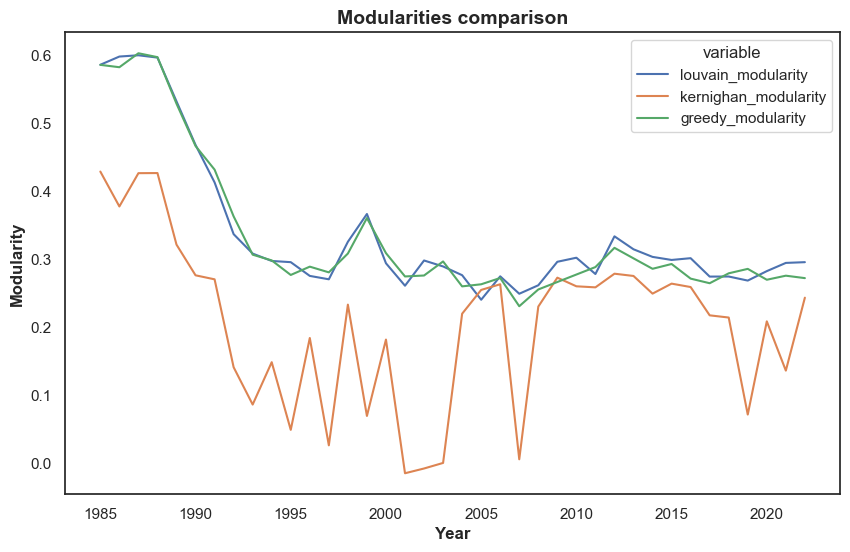

In [216]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Modularities comparison', fontsize=14,fontweight="bold")

plt.xlabel('Year',  fontsize=12, fontweight="bold")
plt.ylabel('Modularity',  fontsize=12, fontweight="bold")
sns.lineplot(data =  pd.melt(nets_table, 
                              id_vars='year', 
                              value_vars =  [ 'louvain_modularity',
                                             'kernighan_modularity' ,
                                             'greedy_modularity']),
              x= 'year', y = 'value', hue = 'variable'
              
             );

The larger is modulariuty (the degree of the network's division) - the better. On average, Louvain clusterization wins.

### Visualizing communities

In [130]:
g1985 = nets_table["net"].iloc[1]
l1985 = nets_table["louvain"].iloc[1]
degrees = dict(g1985.degree)
pos = nx.fruchterman_reingold_layout(g1985, k=0.5)

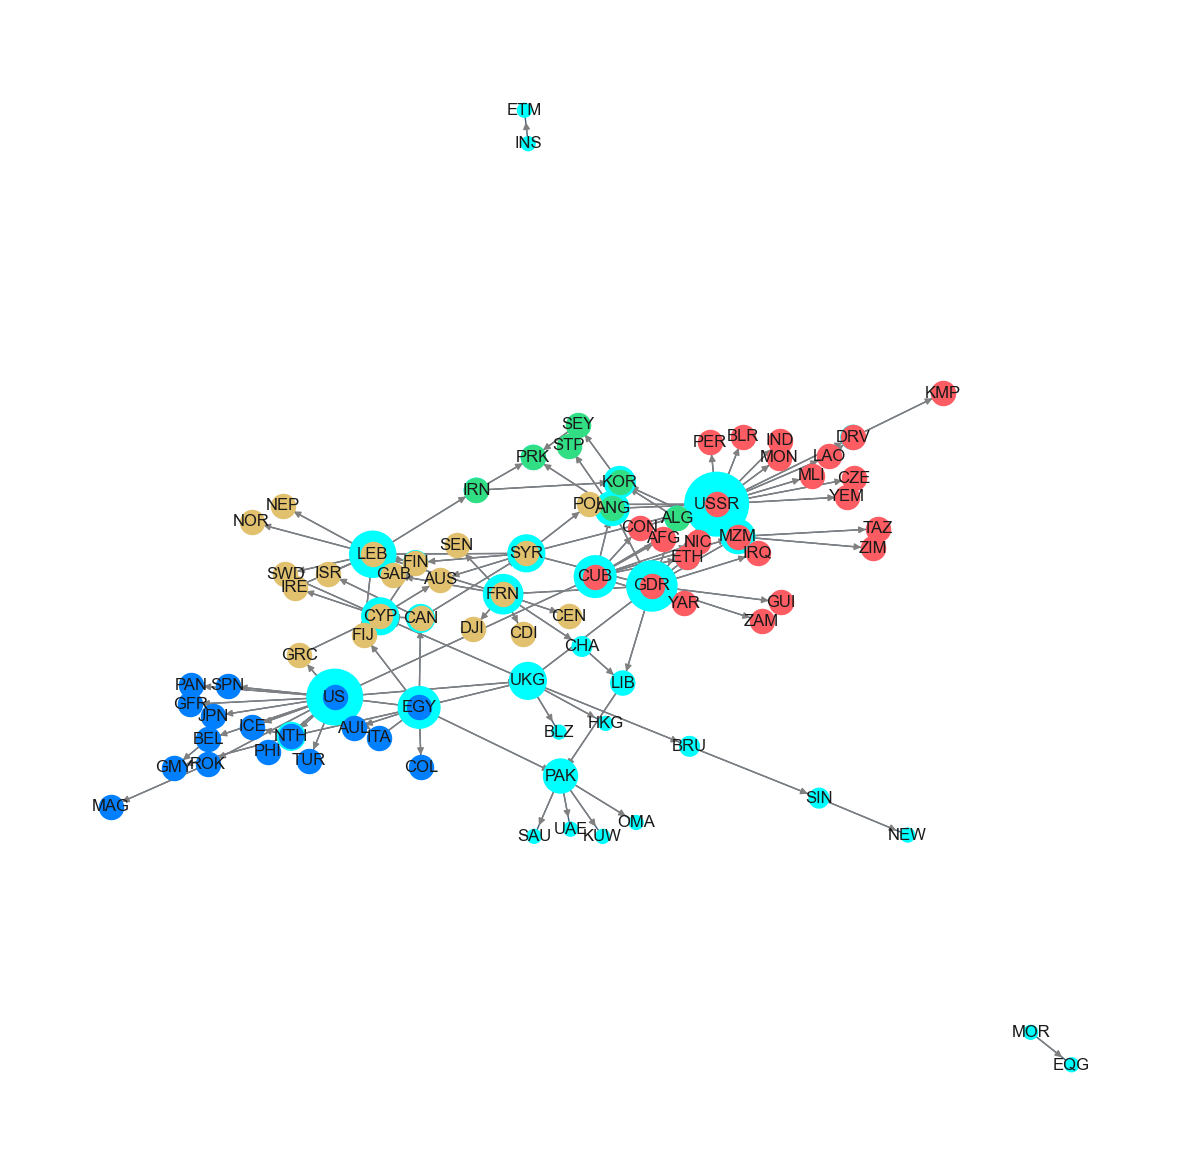

In [218]:
fig, ax = plt.subplots(figsize=(15, 15))
pos = nx.spring_layout(g1985, k=0.12, seed=42)
degrees = dict(g1985.degree)
nx.draw(g1985,
        pos, 
        ax=ax,
        node_color = 'cyan',
        node_size = [v * 100 for v in degrees.values()], 
        edge_color = '#455d7a',
        with_labels = True
     
       )
nx.draw_networkx_nodes(g1985, pos, nodelist=l1985[0], node_color='#007FFF'
                     )
nx.draw_networkx_nodes(g1985, pos, nodelist=l1985[1], node_color='#32de84')
nx.draw_networkx_nodes(g1985, pos, nodelist=l1985[2], node_color='#E1C16E')
nx.draw_networkx_nodes(g1985, pos, nodelist=l1985[3], node_color='#fd5c63')
nx.draw_networkx_edges(g1985,
                       pos, 
                       arrows = True, 
                       width=1, 
                       label="S",
                       arrowstyle='-|>',
                       edge_color = 'gray'
                      );

plt.show()


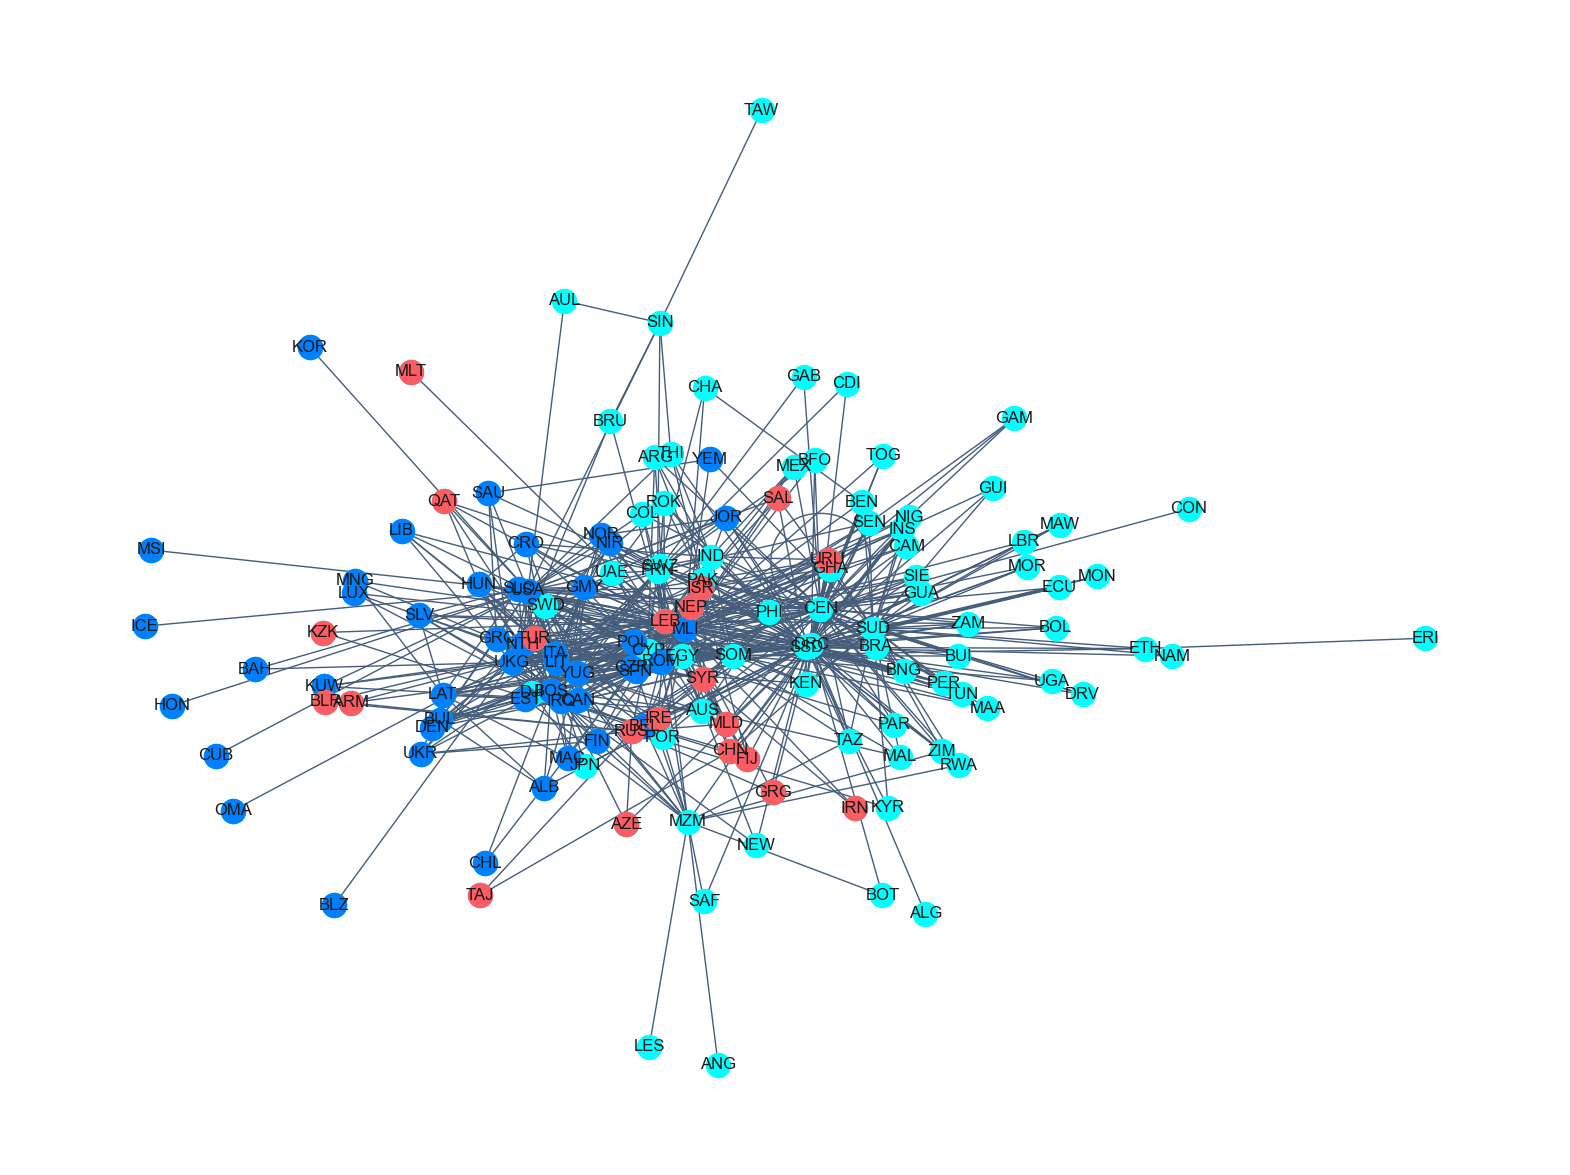

In [209]:
g2022 = nets_table["net"].iloc[-1]
l2022 = nets_table["louvain"].iloc[-1]
degrees = dict(g2022.degree)

fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(g2022, k=0.01, seed=42)
nx.draw(g2022,
        pos, 
        ax=ax,
        node_color = 'cyan',
        
        edge_color = '#455d7a',
        with_labels = True
     
       )

nx.draw_networkx_nodes(g2022, pos, nodelist=l2022[0], node_color='#007FFF')

nx.draw_networkx_nodes(g2022, pos, nodelist=l2022[5], node_color='#fd5c63')